In [254]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Read and Preprocess Data

In [255]:
df = pd.read_csv('../../Data/training_data.csv')

In [256]:
# Drop some data that is unnecessary or has one unique value
df = df.drop(['clli', 'year', 'month', 'date', 'rack', 'shelf', 'objectType', 'Stops_null', 'Stops_NAS-Error', 'Stops_Port-Error', 'Stops_Service-Unavailable', 'Stops_User-Error'], axis=1)
# Drop some data that has too many null values ( > 60000)
df = df.drop(['Stops_Admin-Reset', 'Stops_Idle-Timeout', 'Stops_Lost-Carrier', 'Stops_Lost-Service', 'Stops_NAS-Request', 'Stops_Session-Timeout', 'Stops_User-Request', 'INTENT', 'CALLCOMPLETIONREASON', 'TSO_calls_count', 'REPORT_DATE'], axis=1)
# Drop some data that has too many null values ( > 50000)
df = df.drop(['videoAniAgcSetting', 'videoAniOpInfoOpticalSignalLevel', 'videoAniOpInfoOpticalSignalLevelDbm', 'videoAniOpInfoRfPowerLevel'], axis=1)
# Drop some data that may be too hard to work with (for example: low unique)
df = df.drop(['modemType', 'laserBiasThreshold', 'status', 'ranged', 'videoAniAgcModePlanned', 'videoAniOperState', 'score'], axis=1)
df['berDownstream'] = df['berDownstream'].fillna(df['berDownstream'].median())
df['berUpstream'] = df['berUpstream'].fillna(df['berUpstream'].median())
df['networkRxLevel'] = df['networkRxLevel'].fillna(df['networkRxLevel'].median())
df['modemTxLevel'] = df['modemTxLevel'].fillna(df['modemTxLevel'].median())
df['distance'] = df['distance'].fillna(df['distance'].median())
df['laserBiasCurrent'] = pd.to_numeric(df['laserBiasCurrent'],errors = 'coerce')
df['laserBiasCurrent'] = df['laserBiasCurrent'].fillna(df['laserBiasCurrent'].median())
df['opticalTemperature'] = df['opticalTemperature'].fillna(df['opticalTemperature'].median())
df['service_repair'] = df['service_repair'].fillna(0)

# One hot encoding
labelencoder = LabelEncoder()
df['speedProfile'] = labelencoder.fit_transform(df['speedProfile'])
df['objectName'] = labelencoder.fit_transform(df['objectName'])

## Feature Selection

In [257]:
features = ['berDownstream', 'berUpstream', 'networkRxLevel', 'modemTxLevel', 'distance']
numInputs = len(features)

## Training the Deep Learning Model

In [258]:
X = df[features]
Y = df['service_repair']

Scale data

In [259]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
X_scale

array([[0.00000000e+00, 8.56614493e-06, 6.81818182e-01, 0.00000000e+00,
        3.09278351e-02],
       [0.00000000e+00, 1.19750395e-07, 6.81818182e-01, 8.39010586e-01,
        5.15463918e-02],
       [0.00000000e+00, 5.98751976e-07, 6.81818182e-01, 8.53002830e-01,
        2.06185567e-02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 9.12587413e-01, 9.44974321e-01,
        1.23711340e-01],
       [0.00000000e+00, 0.00000000e+00, 7.69230769e-01, 9.68661566e-01,
        3.53951890e-01],
       [0.00000000e+00, 0.00000000e+00, 6.81818182e-01, 9.62110890e-01,
        1.75257732e-01]])

Split data into testing and validation

In [260]:
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [261]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(44152, 5) (9461, 5) (9462, 5) (44152,) (9461,) (9462,)


In [262]:
from keras.models import Sequential
from keras.layers import Dense

Set up layers

In [263]:
from keras.layers import Dropout
from keras import regularizers

In [264]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(numInputs,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [265]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Train the model

In [266]:
hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=5,
          validation_data=(X_val, Y_val))

Epoch 1/5


1380/1380 [==============================] - 3s 2ms/step - loss: 0.1411 - accuracy: 0.9782 - val_loss: 0.1064 - val_accuracy: 0.9782
Epoch 2/5
1380/1380 [==============================] - 3s 2ms/step - loss: 0.1063 - accuracy: 0.9782 - val_loss: 0.1062 - val_accuracy: 0.9782
Epoch 3/5
1380/1380 [==============================] - 5s 4ms/step - loss: 0.1061 - accuracy: 0.9782 - val_loss: 0.1060 - val_accuracy: 0.9782
Epoch 4/5
1380/1380 [==============================] - 5s 3ms/step - loss: 0.1059 - accuracy: 0.9782 - val_loss: 0.1059 - val_accuracy: 0.9782
Epoch 5/5
1380/1380 [==============================] - 6s 4ms/step - loss: 0.1058 - accuracy: 0.9782 - val_loss: 0.1058 - val_accuracy: 0.9782


## Evaluate Model

In [267]:
model.evaluate(X_test, Y_test)[1]

296/296 [==============================] - 1s 4ms/step - loss: 0.1093 - accuracy: 0.9772


0.9771718382835388

In [268]:
import matplotlib.pyplot as plt

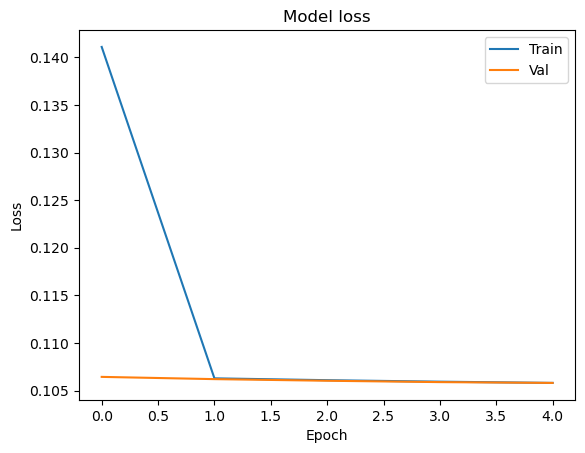

In [269]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

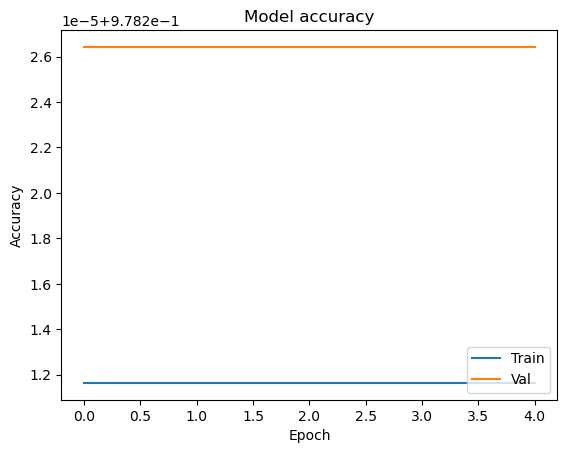

In [270]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

## Predict the Test Data Using Our Model

In [271]:
df2 = pd.read_csv('../../Data/test_data.csv')
df3 = pd.read_csv('../../Data/customers_ToBePredicted.csv')
# Drop some data that is unnecessary or has one unique value
df2 = df2.drop(['clli', 'year', 'month', 'date', 'rack', 'shelf', 'objectType', 'Stops_null', 'Stops_NAS-Error', 'Stops_Port-Error', 'Stops_Service-Unavailable', 'Stops_User-Error'], axis=1)
# Drop some data that has too many null values ( > 60000)
df2 = df2.drop(['Stops_Admin-Reset', 'Stops_Idle-Timeout', 'Stops_Lost-Carrier', 'Stops_Lost-Service', 'Stops_NAS-Request', 'Stops_Session-Timeout', 'Stops_User-Request', 'INTENT', 'CALLCOMPLETIONREASON', 'TSO_calls_count', 'REPORT_DATE'], axis=1)
# Drop some data that has too many null values ( > 50000)
df2 = df2.drop(['videoAniAgcSetting', 'videoAniOpInfoOpticalSignalLevel', 'videoAniOpInfoOpticalSignalLevelDbm', 'videoAniOpInfoRfPowerLevel'], axis=1)
# Drop some data that may be too hard to work with (for example: low unique)
df2 = df2.drop(['modemType', 'laserBiasThreshold', 'status', 'ranged', 'videoAniAgcModePlanned', 'videoAniOperState', 'score'], axis=1)
df2['berDownstream'] = df2['berDownstream'].fillna(df2['berDownstream'].median())
df2['berUpstream'] = df2['berUpstream'].fillna(df2['berUpstream'].median())
df2['networkRxLevel'] = df2['networkRxLevel'].fillna(df2['networkRxLevel'].median())
df2['modemTxLevel'] = df2['modemTxLevel'].fillna(df2['modemTxLevel'].median())
df2['distance'] = df2['distance'].fillna(df2['distance'].median())
df2['laserBiasCurrent'] = pd.to_numeric(df2['laserBiasCurrent'],errors = 'coerce')
df2['laserBiasCurrent'] = df2['laserBiasCurrent'].fillna(df['laserBiasCurrent'].median())
df2['opticalTemperature'] = df2['opticalTemperature'].fillna(df['opticalTemperature'].median())
#df2['service_repair'] = df2['service_repair'].fillna(0)

# One hot encoding
labelencoder = LabelEncoder()
df2['speedProfile'] = labelencoder.fit_transform(df2['speedProfile'])
df2['objectName'] = labelencoder.fit_transform(df2['objectName'])

In [272]:
features

['berDownstream', 'berUpstream', 'networkRxLevel', 'modemTxLevel', 'distance']

In [276]:
import warnings
warnings.filterwarnings('ignore')
import csv
with open("answer2.csv", "w", newline='') as csvfile:
  csvwriter = csv.writer(csvfile, delimiter=',')
  csvwriter.writerow(['Customer', 'service_repair'])
  for i in range(len(df3)-1):
        customerID = int(df3.iloc[[i]].iloc[:,0])
        x_test = df2.loc[customerID == df2['Customer']]
        x_test = x_test[features]
        prediction = model.predict(x_test)
        to_write = int(prediction.max().round())
        csvwriter.writerow([customerID, to_write])


1/1 [==============================] - 0s 21ms/step


In [274]:
model.save("model2.keras")
